In [1]:
from math import sqrt
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec, KeyedVectors
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn import model_selection
from scipy import sparse
import xgboost as xgb
import lightgbm as lgbm

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./cv-statistics-better-parameters.ipynb
./notebookf87e60098c (22).ipynb
./sub11.csv
./submission.csv
./test.json
./test.json.zip
./train.json
./train.json.zip
./.ipynb_checkpoints\cv-statistics-better-parameters-checkpoint.ipynb
./.ipynb_checkpoints\notebookf87e60098c (22)-checkpoint.ipynb


In [2]:
train = pd.read_json('./train.json')
train.info()
train.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
123487,1.0,1,0,2016-04-22 01:12:32,This newly renovated 2 bedroom 1 bathroom apar...,East 88th Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7912,6909151,-73.9794,fe7076077ae23563520d054a917e3544,[https://photos.renthop.com/2/6909151_12f4bdb8...,3300,530 East 88th Street,low
93894,1.0,2,925000562967b40a5fdda4a55617a77f,2016-04-15 04:22:20,I have total market coverage in Manhattan with...,W 105 Street,[],40.7989,6877381,-73.9636,1729cc4d62ab0cec44dcfd6757d44d65,[https://photos.renthop.com/2/6877381_bbb1943e...,2500,103 W 105 Street,high
99716,1.0,0,3c2aae5dc5f56025cb62b20eb762b311,2016-04-27 05:30:57,"Super Spacious, Sun-filled studio just one fli...",East 83rd Street,[],40.7747,6931768,-73.9497,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/6931768_4074eedc...,1800,427 East 83rd Street,low


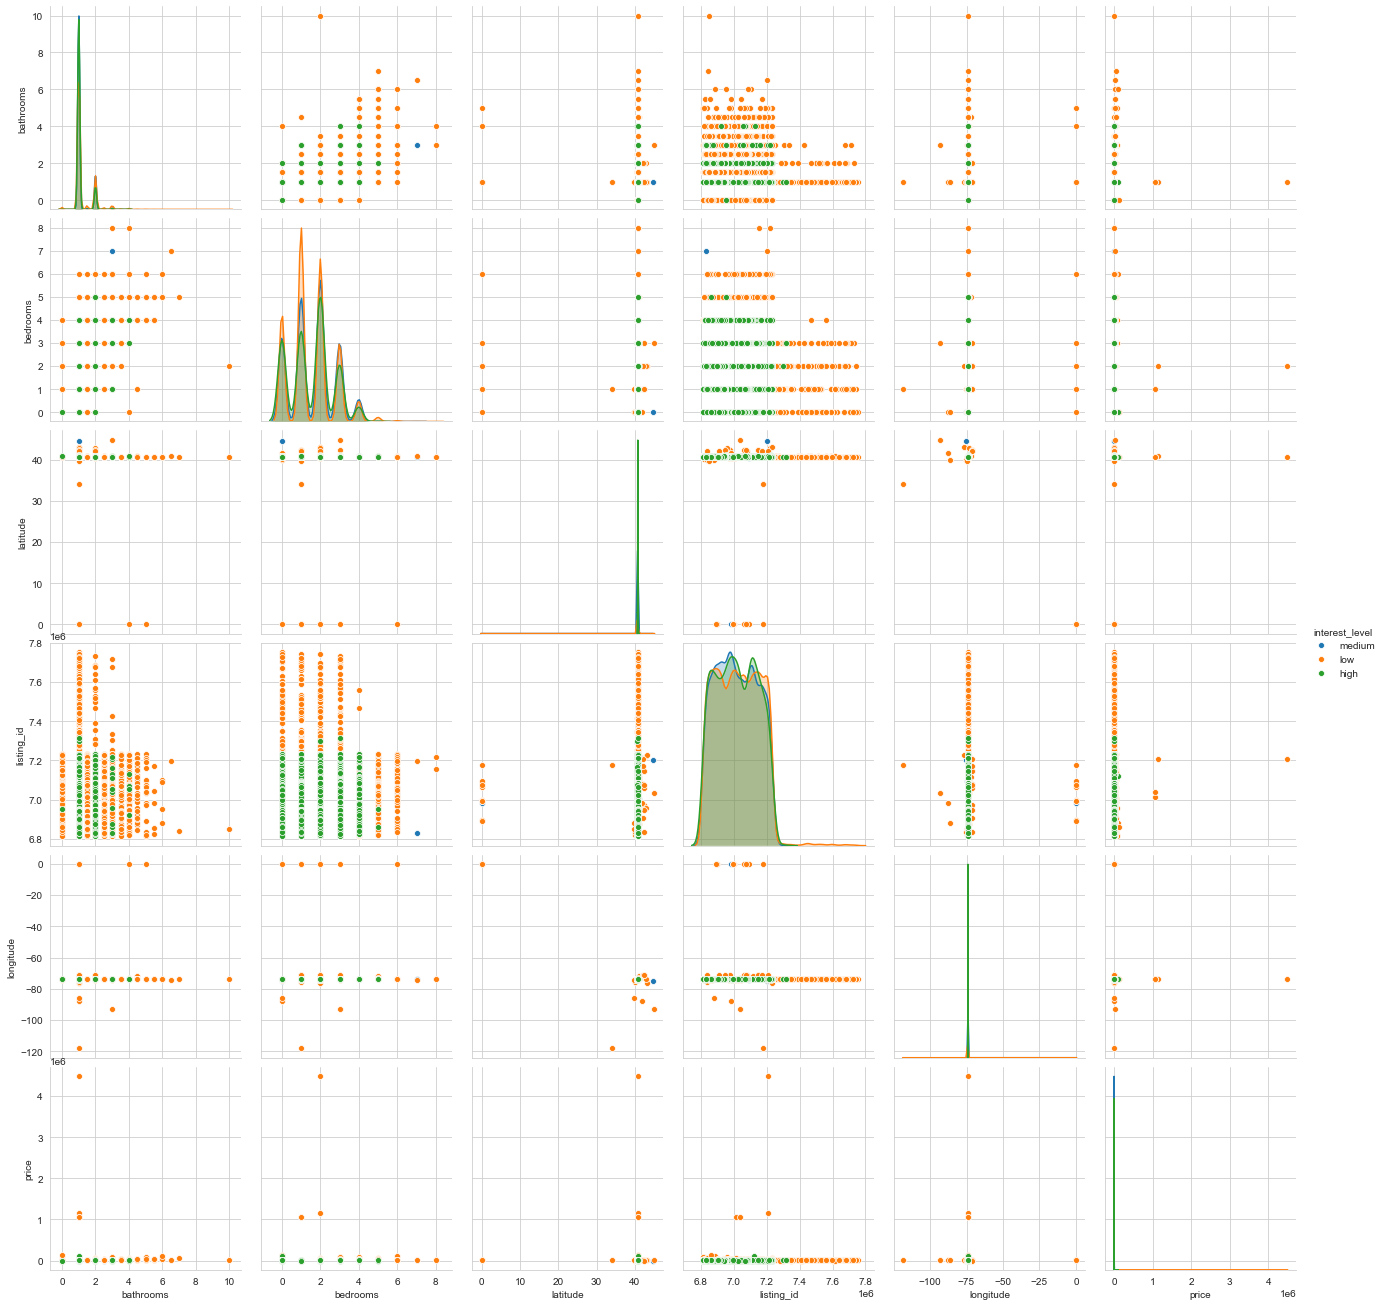

In [3]:
plt.close();
sns.set_style('whitegrid');
sns.pairplot(train, hue='interest_level', height=3);
plt.show()

As we can see, data is linear separable, so using decision trees is a good choice

In [4]:
test = pd.read_json('./test.json')
test.info()
test.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 124010
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        74659 non-null  float64
 1   bedrooms         74659 non-null  int64  
 2   building_id      74659 non-null  object 
 3   created          74659 non-null  object 
 4   description      74659 non-null  object 
 5   display_address  74659 non-null  object 
 6   features         74659 non-null  object 
 7   latitude         74659 non-null  float64
 8   listing_id       74659 non-null  int64  
 9   longitude        74659 non-null  float64
 10  manager_id       74659 non-null  object 
 11  photos           74659 non-null  object 
 12  price            74659 non-null  int64  
 13  street_address   74659 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 8.5+ MB


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
21338,1.0,2,0d01cabe55fa5192cdbcabd5c585c1ea,2016-06-02 16:01:01,Great 2 bedroom apartment features exposed bri...,1av e 13,[No Fee],40.7302,7100350,-73.9826,53f240454714b223c7aaa73437c24e8a,[https://photos.renthop.com/2/7100350_f7059140...,3399,410 e 13
20206,3.0,3,1b8aaa569086f8c70a5333593cbec632,2016-06-16 06:30:13,Monthly rent is $11995 Magnificent Classic 6 i...,E 84th St.,"[Dining Room, Doorman, Elevator, Pre-War, Laun...",40.7795,7170852,-73.9594,d2bce61e0e0079ebdc8c281e415e045b,[https://photos.renthop.com/2/7170852_5f6091d5...,10000,35 E 84th St.
113031,1.0,0,50a05235aa5ca13ec2c482538a8ebf9b,2016-04-11 16:48:02,THIS IS THE ONE THAT WILL END YOUR SEARCH!!! ...,midtown west - 6th ave,[** MIDTOWN MANIA! * SUPER SEXY STUDIO * ALL M...,40.7588,6856758,-73.9836,699c325b818541f314b691b76f3238d7,[https://photos.renthop.com/2/6856758_99e7cac1...,2100,151 W 47th St


In [5]:
test['bathrooms'].loc[19671] = 1.5
test['bathrooms'].loc[22977] = 2.0
test['bathrooms'].loc[63719] = 2.0
train['price'] = train['price'].clip(upper=13000)

C:\Users\User\anaconda3\envs\ml\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### There is no missing values and all data match their types

# Feature engineering

## 1) Features from 'display_address'

In [6]:
# I will arrange street types by their interest_level

street_types = ['turnpike', 'expressway', ' road', 'lane', 'ave', 'place', 'boulevard', 'highway', 'plaza']
# To each street type we correspond quantity of interest_level of the certain type  
street_type_counts = {t:{'low':0, 'medium':0, 'high':0} for t in street_types}  
# We don't need these two in the original list, so we don't add them from the street_types (but they will be in the street_type_counts dictionary)
street_type_counts['street'] = {'low':0, 'medium':0, 'high':0}
street_type_counts['other'] = {'low':0, 'medium':0, 'high':0}

train['display_address'] = train['display_address'].apply(lambda x: x.lower())  # Convert each address into a lower register 
        
for i, address in enumerate(train['display_address'].values):  # For every example
    for st_type in street_types:  # For every street type
        if st_type in address:  # We correspond a number
            if train['interest_level'].values[i] == 'low':
                street_type_counts[st_type]['low'] += 1
            elif train['interest_level'].values[i] == 'medium':
                street_type_counts[st_type]['medium'] += 1
            else:
                street_type_counts[st_type]['high'] += 1
        continue

    if (' st' in address or 'th' in address):
        if train['interest_level'].values[i] == 'low':
            street_type_counts['street']['low'] += 1
        elif train['interest_level'].values[i] == 'medium':
            street_type_counts['street']['medium'] += 1
        else:
            street_type_counts['street']['high'] += 1

    else:
        if train['interest_level'].values[i] == 'low':
            street_type_counts['other']['low'] += 1
        elif train['interest_level'].values[i] == 'medium':
            street_type_counts['other']['medium'] += 1
        else:
            street_type_counts['other']['high'] += 1
street_type_counts

{'turnpike': {'low': 0, 'medium': 1, 'high': 1},
 'expressway': {'low': 5, 'medium': 1, 'high': 0},
 ' road': {'low': 89, 'medium': 35, 'high': 24},
 'lane': {'low': 109, 'medium': 37, 'high': 11},
 'ave': {'low': 5585, 'medium': 1874, 'high': 818},
 'place': {'low': 582, 'medium': 192, 'high': 68},
 'boulevard': {'low': 239, 'medium': 28, 'high': 13},
 'highway': {'low': 3, 'medium': 0, 'high': 0},
 'plaza': {'low': 59, 'medium': 0, 'high': 2},
 'street': {'low': 27104, 'medium': 8743, 'high': 2849},
 'other': {'low': 7180, 'medium': 2486, 'high': 990}}

In [7]:
# I multiply the number of examples by factors that correspond to their degree of significance. So the more quality, the more weight. 
# Then I divide it all by the sum of all examples for the given street_type 

interest = {}
for k in street_type_counts.keys():
    num_examples = street_type_counts[k]['low'] + street_type_counts[k]['medium'] + street_type_counts[k]['high']
    if num_examples != 0:
        value = (street_type_counts[k]['low']*1 + street_type_counts[k]['medium']*3 + street_type_counts[k]['high']*5) / num_examples
    else:
        value = 0
    interest[k] = value
interest

{'turnpike': 4.0,
 'expressway': 1.3333333333333333,
 ' road': 2.1216216216216215,
 'lane': 1.7515923566878981,
 'ave': 1.8481333816600218,
 'place': 1.7790973871733966,
 'boulevard': 1.3857142857142857,
 'highway': 1.0,
 'plaza': 1.1311475409836065,
 'street': 1.746382054992764,
 'other': 1.8382132132132132}

In [8]:
sorted(interest, key=interest.get)

['highway',
 'plaza',
 'expressway',
 'boulevard',
 'street',
 'lane',
 'place',
 'other',
 'ave',
 ' road',
 'turnpike']

In [9]:
# Create new features using display_address. 

def create_type_of_street_feature(df):
    df['display_address'] = df['display_address'].apply(lambda x: x.lower())

    temp_list = [0]*df.shape[0] 

    for i, address in enumerate(df['display_address'].values):  # For every example 
        if 'highway' in address:
            temp_list[i] = 0
        elif 'plaza' in address:
            temp_list[i] = 1
        elif 'expressway' in address:
            temp_list[i] = 2
        elif 'boulevard' in address:
            temp_list[i] = 3
        elif 'lane' in address:
            temp_list[i] = 5
        elif 'place' in address:
            temp_list[i] = 6
        elif 'ave' in address:
            temp_list[i] = 8
        elif ' road' in address:
            temp_list[i] = 9
        elif 'turnpike' in address:
            temp_list[i] = 10
        elif (' st' in address or 'th' in address):  # If street 
            temp_list[i] = 4
        else:  # If other 
            temp_list[i] = 7

    df['type_of_street'] = temp_list
    return df
create_type_of_street_feature(train)
create_type_of_street_feature(test)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,type_of_street
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,suffolk street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street,4
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,thompson street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street,4
2,1.0,0,0,2016-06-17 01:23:39,Spacious studio in Prime Location. Cleanbuildi...,sullivan street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7260,7174566,-74.0026,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/7174566_ba3a35c5...,2295,115 Sullivan Street,4
3,1.0,2,f9c826104b91d868e69bd25746448c0c,2016-06-21 05:06:02,For immediate access call Bryan.<br /><br />Bo...,jones street,"[Hardwood Floors, Dogs Allowed, Cats Allowed]",40.7321,7191391,-74.0028,41735645e0f8f13993c42894023f8e58,[https://photos.renthop.com/2/7191391_8c2f2d49...,2900,23 Jones Street,4
5,1.0,1,81062936e12ee5fa6cd2b965698e17d5,2016-06-16 07:24:27,Beautiful TRUE 1 bedroom in a luxury building ...,exchange place,"[Roof Deck, Doorman, Elevator, Fitness Center,...",40.7054,7171695,-74.0095,a742cf7dd3b2627d83417bc3a1b3ec96,[https://photos.renthop.com/2/7171695_089ffee2...,3254,20 Exchange Place,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124003,1.0,1,bd863d28a6b119ac3bc72d5f27b07f24,2016-04-26 16:09:55,BRAND NEW TO MARKET 1BDR \r107TH AND LEXINGTON...,150 east 107th street,[],40.7925,6928108,-73.9454,453d46f8113e1f2c730c2ee5a4469c71,[https://photos.renthop.com/2/6928108_231eb983...,1700,158 EAST 107TH STREET,4
124005,1.0,2,9174b75c0cd978eb0e5aa93afbad754b,2016-04-21 05:06:19,Convertible 2BR apartment features a brand new...,e 33rd st.,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7456,6906674,-73.9797,2983e45f7e0ad87d677dacd13e362785,[https://photos.renthop.com/2/6906674_9fe899a8...,4195,141 E 33rd St.,4
124006,1.0,0,0,2016-04-20 01:31:52,"Let's get you in to see this $2,400/mo, recent...",lexington avenue,"[Dogs Allowed, Cats Allowed]",40.7416,6897967,-73.9829,e6472c7237327dd3903b3d6f6a94515a,[],2400,95 Lexington Avenue,8
124007,2.0,2,c90c010e5505365676538e64d02aa1e0,2016-04-08 02:26:45,CooperCooper.com :: Web ID #171357; Access 100...,park avenue,"[Doorman, Elevator, Cats Allowed, Dogs Allowed]",40.7485,6842183,-73.9800,6e5c10246156ae5bdcd9b487ca99d96a,[https://photos.renthop.com/2/6842183_b1fe51f4...,6895,41 Park Avenue,8


In [10]:
# Let's convert target feature into the numbers
interest_dict = {'low': 0, 'medium': 1, 'high': 2}
train['interest_level'] = train['interest_level'].map(interest_dict)

## 2) Create features from coordinated ('latitude', 'longitude')

In [11]:
# Famous places of New York and their coordinates

area_names = ['Statue_of_Liberty', 'Central_Park', 'Rockefeller_Center_&_Top_of_the_Rock_Observation_Deck', 'Metropolitan_Museum_of_Art' , 
          'Broadway_and_the_Theater_District', 'Empire_State_Building', '9/11_Memorial_and_Museum', 'High_Line', 'American_Museum_of_Natural_History',
         'Times_Square', 'Brooklyn_Bridge', 'Fifth_Avenue', 'Grand_Central_Terminal', 'Lincoln_Center', 'One_World_Observatory', 'The_Frick_Collection',
         'New_York_Public_Library', 'Wall_Street', 'Radio_City_Music_Hall', "St_Patricks_Cathedral", 'Carnegie_Hall', 'Bryant_Park']

latitude_places = [40.689247, 40.785091, 40.759060, 40.779434, 40.790886, 40.748817, 40.711449, 40.747993, 38.891014, 40.758896, 40.706001, 40.773998, 
              40.752655, 40.772392, 40.713020, 40.770949, 40.753181, 40.706005, 40.759979, 40.758160, 43.0527778, 40.753742]

longitude_places = [-74.044502, -73.968285, -73.979431, -73.963402, -73.974709, -73.985428, -74.013855, -74.004890, -77.026703, -73.985130, -73.997002, 
             -73.966003, -73.977295, -73.984070, -74.013191, -73.96731, -73.982254, -74.008827, -73.980049, -73.975418, -75.4063889, -73.983559]

areas_df = pd.DataFrame({'area_names': area_names, 'latitude': latitude_places, 'longitude': longitude_places})
    
def create_coordinate_feature(df):
    df['total_distance'] = list(np.zeros(df.shape[0]))  # Create a new empty feature (sum of distances from example to all famous areas of New York)

    for i,name in enumerate(areas_df['area_names']):
        df['latitude_diff_'+ name] = df['latitude'].apply(lambda x: abs(x - areas_df['latitude'][i]))
        df['longitude_diff_'+ name] = df['longitude'].apply(lambda x: abs(x - areas_df['longitude'][i]))
        df['total_distance'] += df[['latitude_diff_'+ name, 'longitude_diff_'+ name]].apply(lambda x: sqrt(x[0]**2 + x[1]**2), axis=1)  # By euclidean distance   
    return
                                                            
create_coordinate_feature(train)
create_coordinate_feature(test)                                                           

In [12]:
train['pos'] = train.longitude.round(3).astype(str) + '_' + train.latitude.round(3).astype(str)
test['pos'] = test.longitude.round(3).astype(str) + '_' + test.latitude.round(3).astype(str)

vals = train['pos'].value_counts()
dvals = vals.to_dict()
train['density'] = train['pos'].apply(lambda x: dvals.get(x, vals.min()))
test['density'] = test['pos'].apply(lambda x: dvals.get(x, vals.min()))

<AxesSubplot:>

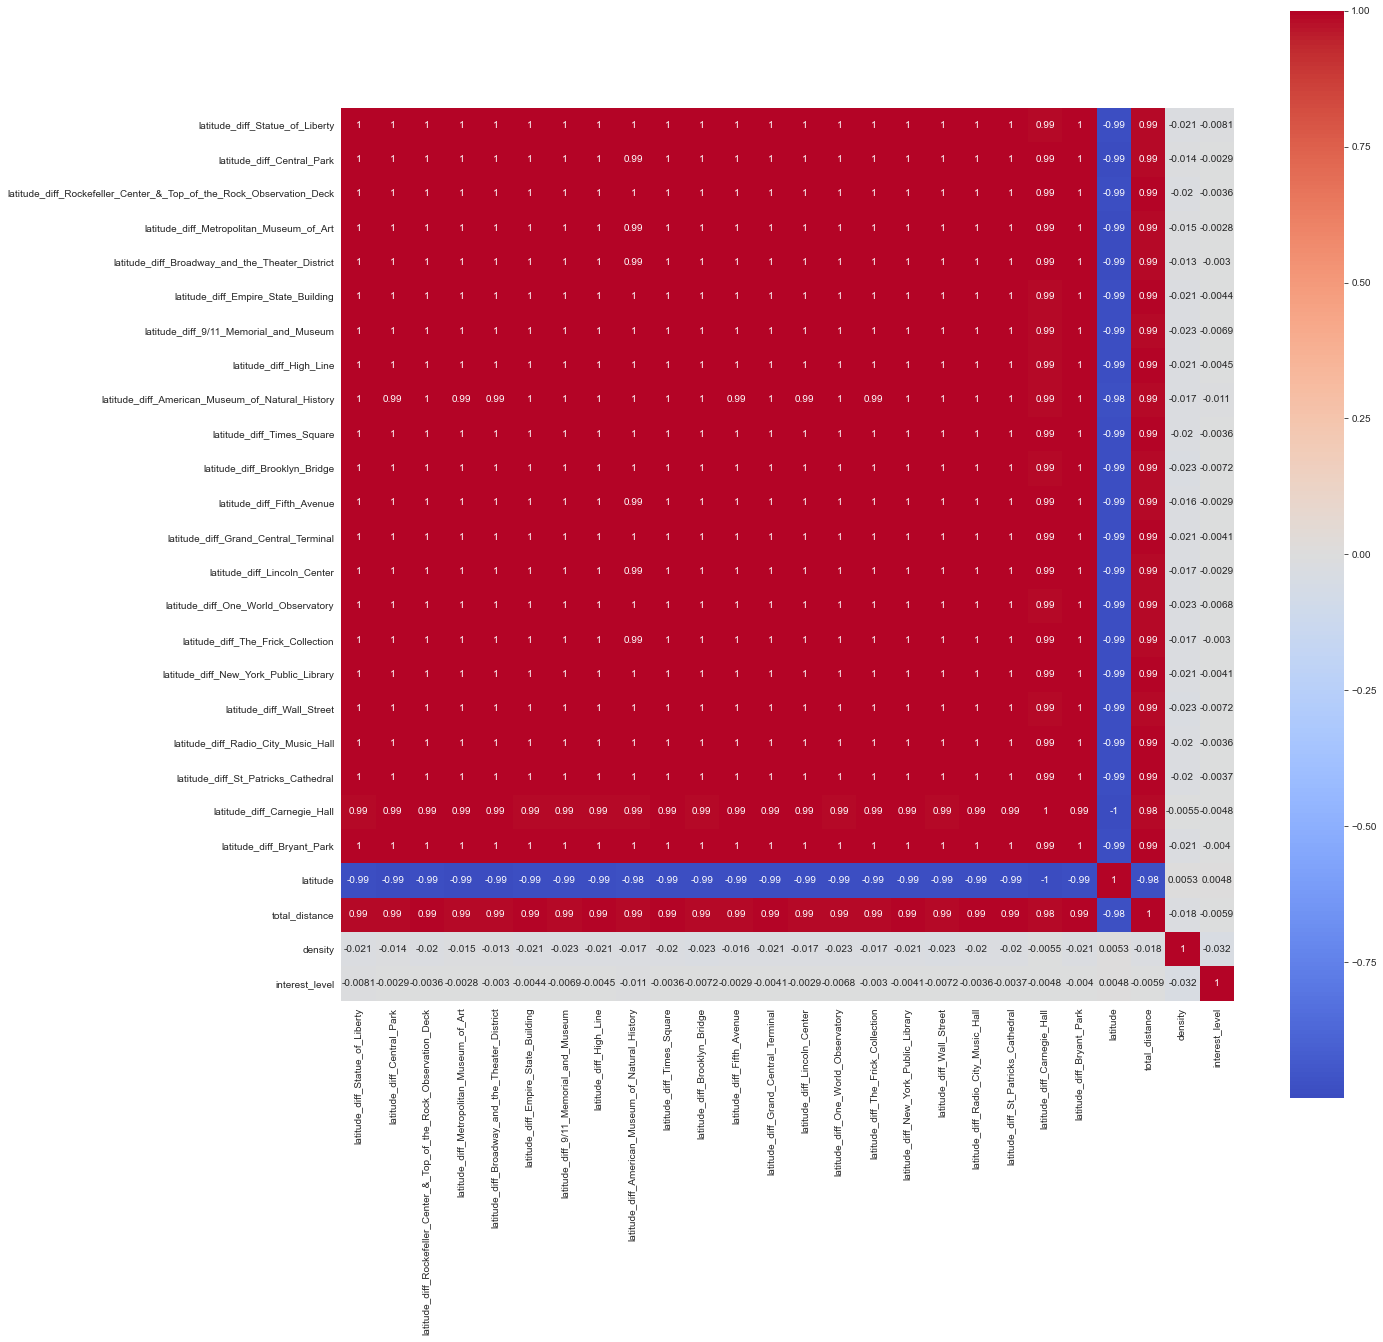

In [13]:
latitude_features = []
longitude_features = []

for i,name in enumerate(areas_df['area_names']):
    latitude_features.append('latitude_diff_' + name)
    longitude_features.append('longitude_diff_' + name)   
  

latitude_features.append('latitude') 
latitude_features.append('total_distance') 
latitude_features.append('pos')
latitude_features.append('density')
latitude_features.append('interest_level')  # We compare this features with target feature 

fig, axs = plt.subplots(nrows=1, figsize=(20, 20))
sns.heatmap(train[latitude_features].corr(), annot=True, square=True, cmap='coolwarm')

<AxesSubplot:>

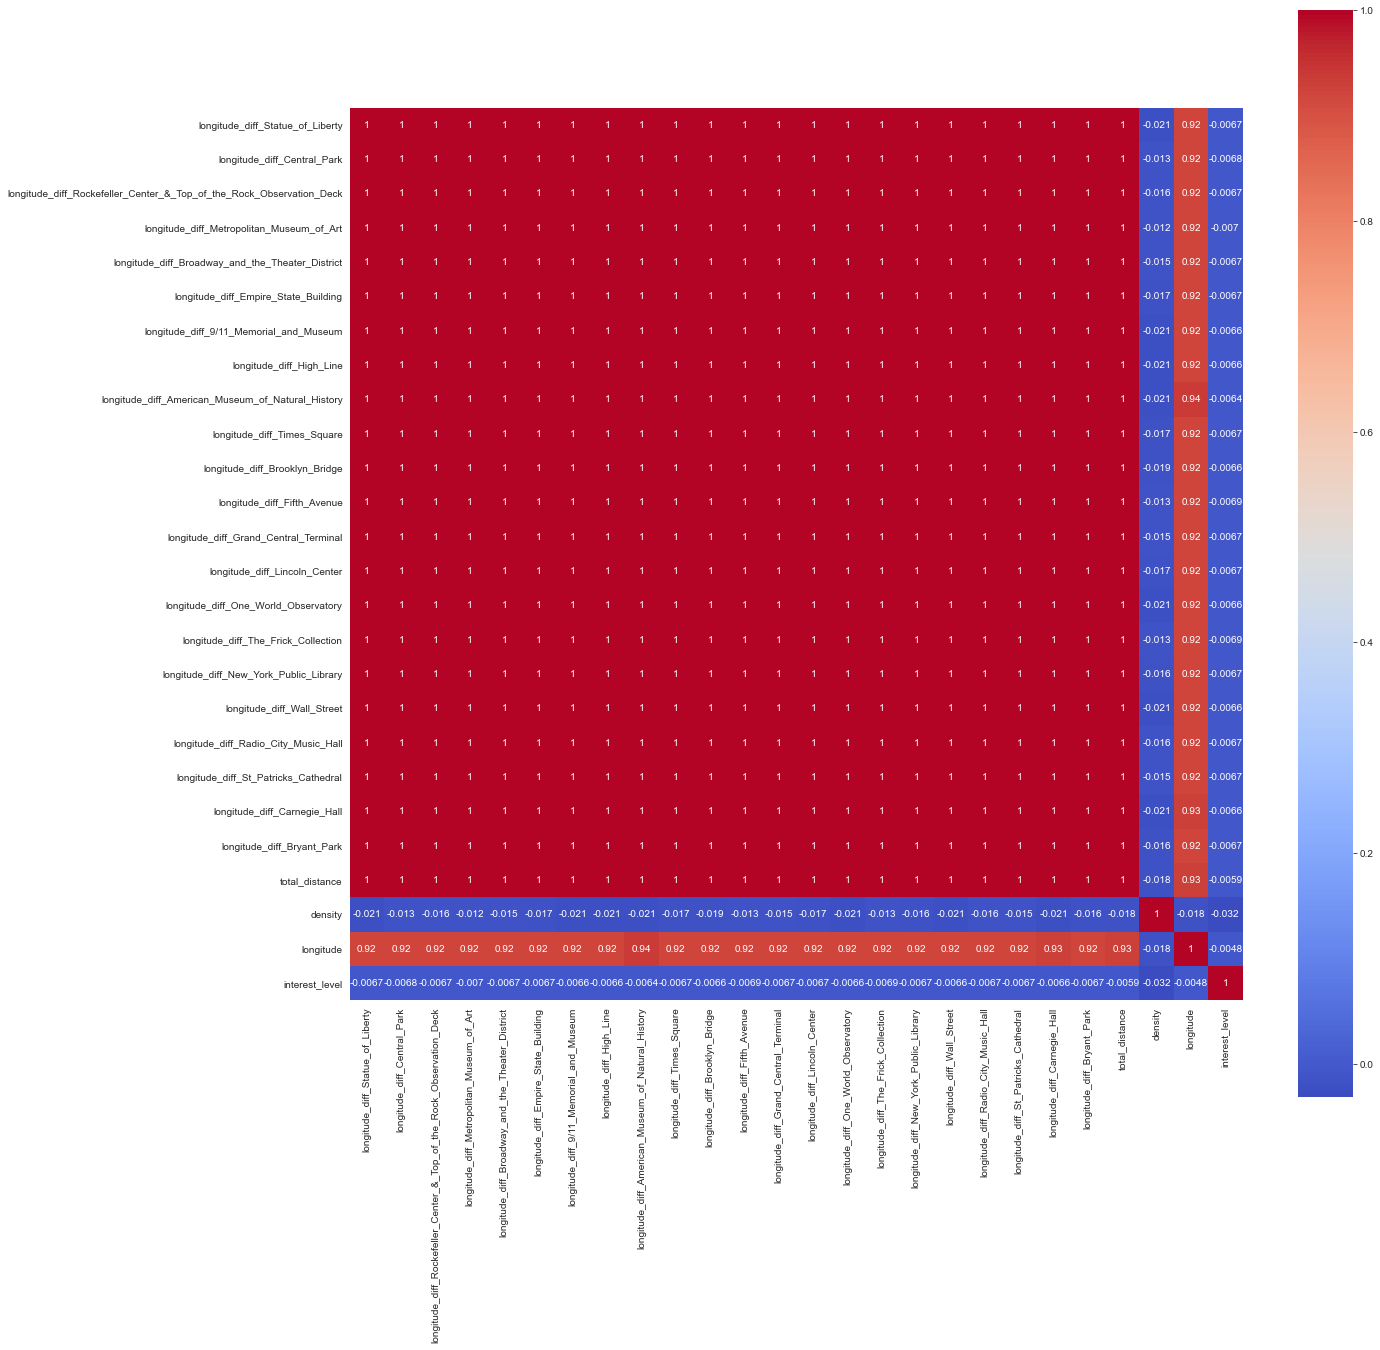

In [14]:
longitude_features.append('total_distance') 
longitude_features.append('pos')
longitude_features.append('density')
longitude_features.append('longitude') 
longitude_features.append('interest_level')  # We compare this features with target feature 

fig, axs = plt.subplots(nrows=1, figsize=(20, 20))
sns.heatmap(train[longitude_features].corr(), annot=True, square=True, cmap='coolwarm')

## 3) Create other features

In [15]:
def create_many_features(df):  
    # Rooms
    df['has_bathroom'] = df['bathrooms'].apply(lambda x: 1 if x > 0 else 0)
    df['has_bedroom'] = df['bedrooms'].apply(lambda x: 1 if x > 0 else 0)    
    df['half_bathroom'] = df['bathrooms'].apply(lambda x: 1 if x*10%10 == 5 else 0)
    df['half_bedroom'] = df['bedrooms'].apply(lambda x: 1 if x*10%10 == 5 else 0)    
    df['price_per_bedrooms'] = df["price"] / df["bedrooms"]
    df['total_rooms'] = df['bathrooms'] + df['bedrooms']
    
    rooms_features = ['has_bathroom', 'has_bedroom', 'half_bathroom', 
                      'half_bedroom', 'price_per_bedrooms', 'total_rooms']
    
    #Price
    df['logprice'] = np.log(df['price'])
    df['price_per_bedrooms'] = df['price'] / df['bedrooms']
    df['price_per_room'] = df['price'] / df['total_rooms']
    
    price_features = ['logprice', 'price_per_bedrooms', 'price_per_room']

    # Datetime
    df['created'] = pd.to_datetime(df['created'], format='%Y-%m-%d %H:%M:%S')

    df['winter_created'] = df['created'].apply(lambda x: 1 if x.month == 12 or 1 <= x.month <= 2 else 0)
    df['spring_created'] = df['created'].apply(lambda x: 1 if 3 <= x.month <= 5 else 0)
    df['summer_created'] = df['created'].apply(lambda x: 1 if 6 <= x.month <= 8 else 0)
    df['autumn_created'] = df['created'].apply(lambda x: 1 if 9 <= x.month <= 11 else 0)

    df['dayofweek_created'] = df['created'].apply(lambda x: x.dayofweek)
    df['month_begin'] = df['created'].apply(lambda x: 1 if 3 <= x.day <= 5 else 0)
    df['month_mid'] = df['created'].apply(lambda x: 1 if 6 <= x.day <= 8 else 0)
    df['month_end'] = df['created'].apply(lambda x: 1 if 9 <= x.day <= 11 else 0)
    
    df['created_year'] = df['created'].dt.year    
    df['created_month'] = df['created'].dt.month
    df['created_day'] = df['created'].dt.day
    df['created_hour'] = df['created'].dt.hour
    
    date_features = ['winter_created', 'spring_created', 'summer_created', 'autumn_created', 
                     'dayofweek_created', 'month_begin', 'month_mid', 'month_end','created_year',
                    'created_month', 'created_day', 'created_hour']

    # Some text features
    df['word_count'] = df['description'].apply(lambda x: len(str(x).split()))
    df['unique_word_count'] = df['description'].apply(lambda x: len(set(str(x).split())))   
    df['stop_words_count'] = df['description'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))
    df['mean_word_length'] = df['description'].apply(lambda x: np.mean(len(str(x).split())))
    df['char_count'] = df['description'].apply(lambda x: len(str(x)))
    df['punctuation_count'] = df['description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df['question_mark_count'] = df['description'].apply(lambda x: x.count('?'))
    df['comma_mark_count'] = df['description'].apply(lambda x: x.count(','))
    df['point_count'] = df['description'].apply(lambda x: x.count('.'))
    df['ellipsis_count'] = df['description'].apply(lambda x: x.count('...'))
    df['num_of_#'] = df['description'].apply(lambda x: x.count('#'))
    df['num_of_!'] = df['description'].apply(lambda x: x.count('!'))
    df['num_of_$'] = df['description'].apply(lambda x: x.count('$'))
    df['num_of_*'] = df['description'].apply(lambda x: x.count('*'))
    df['num_of_>'] = df['description'].apply(lambda x: x.count('>'))
    df['num_features'] = df['features'].apply(len)
    df['num_description_words'] = df['description'].apply(lambda x: len(x.split(" ")))
    
    text_features = ['word_count', 'unique_word_count', 'stop_words_count', 'mean_word_length', 'char_count', 'punctuation_count', 
                     'question_mark_count', 'comma_mark_count', 'point_count', 'ellipsis_count', 'num_of_#', 
                     'num_of_!', 'num_of_$', 'num_of_*', 'num_of_>', 'num_features', 'num_description_words']
    
    # Photos
    df['num_of_photos'] = df['photos'].apply(lambda x:len(x))
    df['photos_per_room'] = df[['num_of_photos','total_rooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
    df['photos_per_bedroom'] = df[['num_of_photos','bedrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
    df['photos_per_bathroom'] = df[['num_of_photos','bathrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
    
    photos_features = ['num_of_photos', 'photos_per_room', 'photos_per_bedroom', 'photos_per_bathroom']    
    return rooms_features, date_features, text_features, photos_features, price_features

rooms_features, date_features, text_features, photos_features, price_features = create_many_features(train)
create_many_features(test)

(['has_bathroom',
  'has_bedroom',
  'half_bathroom',
  'half_bedroom',
  'price_per_bedrooms',
  'total_rooms'],
 ['winter_created',
  'spring_created',
  'summer_created',
  'autumn_created',
  'dayofweek_created',
  'month_begin',
  'month_mid',
  'month_end',
  'created_year',
  'created_month',
  'created_day',
  'created_hour'],
 ['word_count',
  'unique_word_count',
  'stop_words_count',
  'mean_word_length',
  'char_count',
  'punctuation_count',
  'question_mark_count',
  'comma_mark_count',
  'point_count',
  'ellipsis_count',
  'num_of_#',
  'num_of_!',
  'num_of_$',
  'num_of_*',
  'num_of_>',
  'num_features',
  'num_description_words'],
 ['num_of_photos',
  'photos_per_room',
  'photos_per_bedroom',
  'photos_per_bathroom'],
 ['logprice', 'price_per_bedrooms', 'price_per_room'])

<AxesSubplot:>

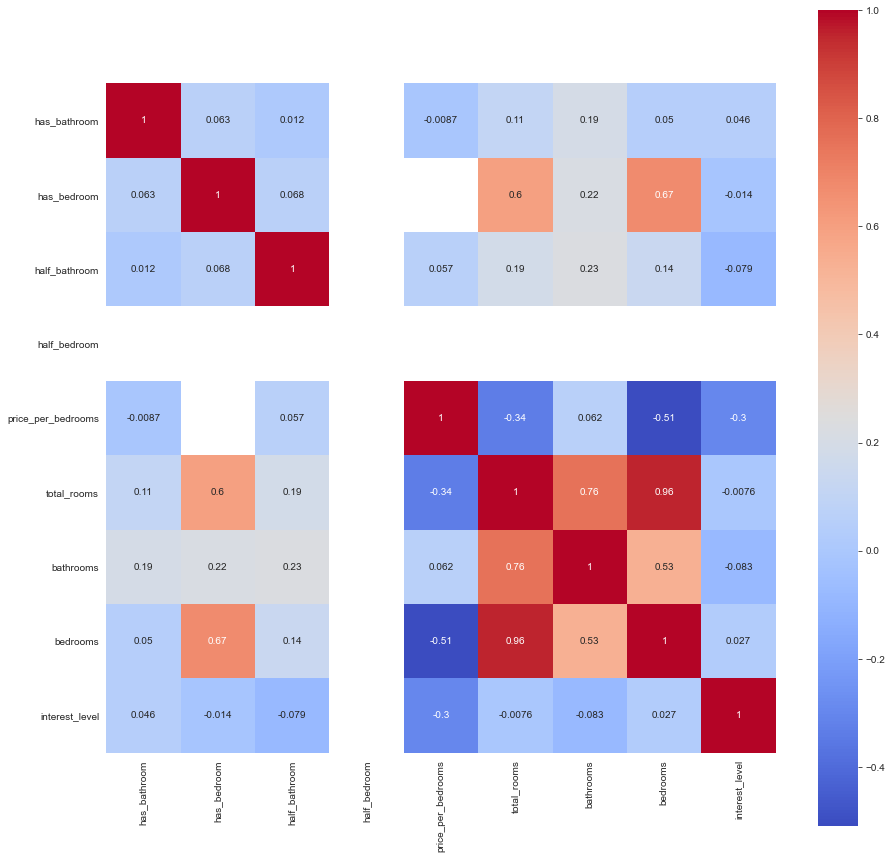

In [16]:
rooms_features.append('bathrooms')
rooms_features.append('bedrooms')
rooms_features.append('interest_level')  # We compare this features with target feature 
fig, axs = plt.subplots(nrows=1, figsize=(15, 15))
sns.heatmap(train[rooms_features].corr(), annot=True, square=True, cmap='coolwarm')

<AxesSubplot:>

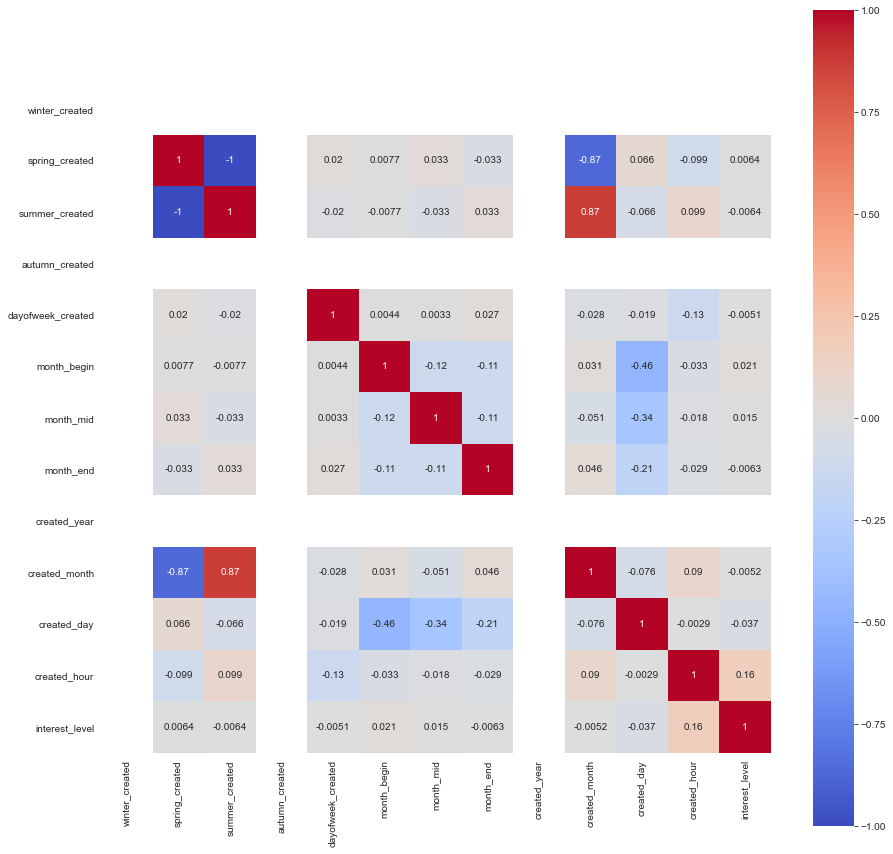

In [17]:
date_features.append('interest_level')  # We compare this features with target feature 
fig, axs = plt.subplots(nrows=1, figsize=(15, 15))
sns.heatmap(train[date_features].corr(), annot=True, square=True, cmap='coolwarm')

<AxesSubplot:>

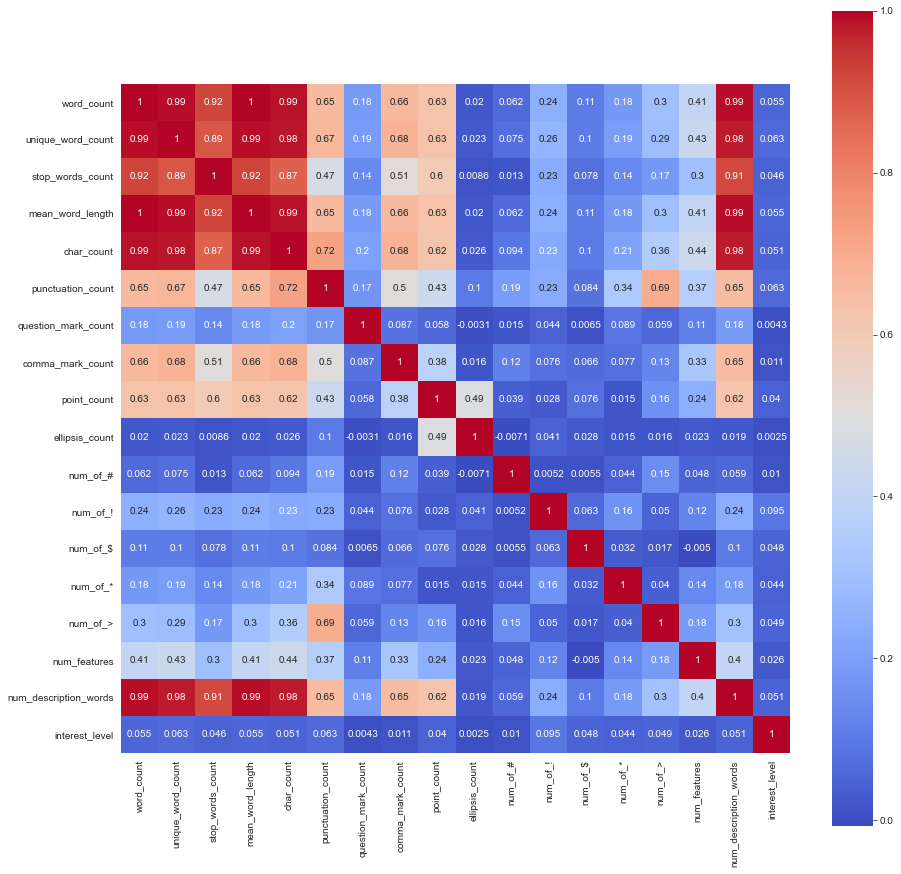

In [18]:
text_features.append('interest_level')  # We compare this features with target feature 
fig, axs = plt.subplots(nrows=1, figsize=(15, 15))
sns.heatmap(train[text_features].corr(), annot=True, square=True, cmap='coolwarm')

<AxesSubplot:>

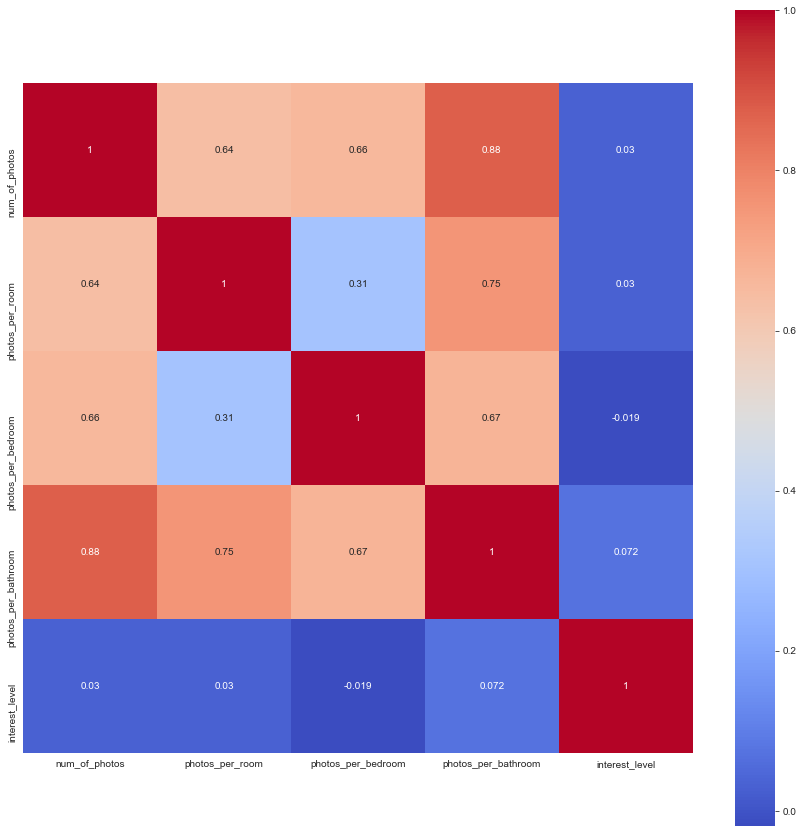

In [19]:
photos_features.append('interest_level')  # We compare this features with target feature 
fig, axs = plt.subplots(nrows=1, figsize=(15, 15))
sns.heatmap(train[photos_features].corr(), annot=True, square=True, cmap='coolwarm')

<AxesSubplot:>

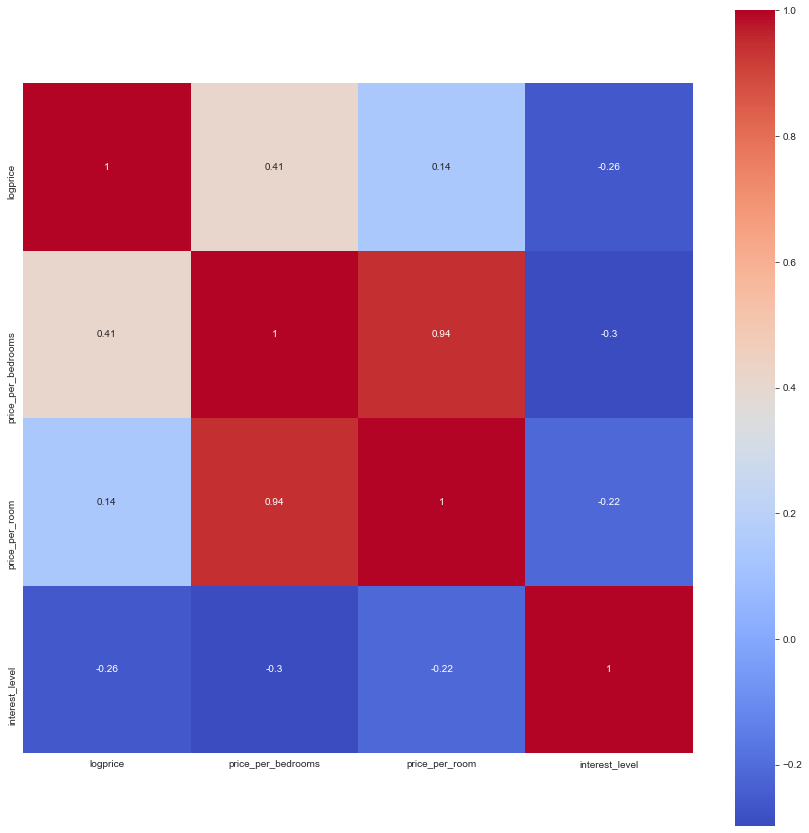

In [20]:
price_features.append('interest_level')  # We compare this features with target feature 
fig, axs = plt.subplots(nrows=1, figsize=(15, 15))
sns.heatmap(train[price_features].corr(), annot=True, square=True, cmap='coolwarm')

In [21]:
features_to_use = ['price', 'price_per_bedrooms', 'logprice', 'bathrooms', 'bedrooms', 'price_per_room',
                   'num_features', 'num_description_words', 'num_of_photos', 'total_distance', 'density', 
                   'created_year', 'created_month', 'created_day', 'created_hour', 'listing_id']

## 4) New features from 'features'

In [22]:
# In df['features'] every example is a list like ['Doorman', 'Elevator', 'Laundry in Building', 'Dishwasher', 'Hardwood Floors', 'No Fee'].
# If but some of elements in this lists consists of several words like 'Hardwood Floors'. So we need to combine this words with '_'  ('Hardwood_Floors').

train['features'] = train['features'].apply(lambda x: ' '.join(['_'.join(elem.split(' ')) for elem in x]))
test['features'] = test['features'].apply(lambda x: ' '.join(['_'.join(elem.split(' ')) for elem in x]))

def clean(df):
    for t in df['features']:
        t = t.replace("twenty four hour", "24")
        t = t.replace("24/7", "24")
        t = t.replace("24hr", "24")
        t = t.replace("24-hour", "24")
        t = t.replace("24hour", "24")
        t = t.replace("24 hour", "24")
    return

clean(train)
clean(test)

In [23]:
cv = CountVectorizer(stop_words='english', max_features=200)
feat_train = cv.fit_transform(train['features'])
feat_test = cv.transform(test['features'])

## 5) Convert text into numerical features

In [24]:
stemmer = PorterStemmer()
def clean_text(df):    
    for text in df:
        text = text.lower()
        text = re.sub(r'<br />','', text)
        text = re.sub(r'<p>', '', text)
        text = re.sub(r'<a', '', text)
        text = re.sub(r'\r', '', text)
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords.words('english')]
        text = ' '.join(text)
    return df

## 6) Create other features

In [25]:
index=list(range(train.shape[0]))
random.shuffle(index)
a=[np.nan]*len(train)
b=[np.nan]*len(train)
c=[np.nan]*len(train)

for i in range(5):
    building_level={}
    for j in train['manager_id'].values:
        building_level[j]=[0,0,0]
    
    test_index=index[int((i*train.shape[0])/5):int(((i+1)*train.shape[0])/5)]
    train_index=list(set(index).difference(test_index))
    
    for j in train_index:
        temp=train.iloc[j]
        if temp['interest_level'] == 0:
            building_level[temp['manager_id']][0]+=1
        if temp['interest_level'] == 1:
            building_level[temp['manager_id']][1]+=1
        if temp['interest_level'] == 2:
            building_level[temp['manager_id']][2]+=1
            
    for j in test_index:
        temp=train.iloc[j]
        if sum(building_level[temp['manager_id']])!=0:
            a[j]=building_level[temp['manager_id']][0]*1.0/sum(building_level[temp['manager_id']])
            b[j]=building_level[temp['manager_id']][1]*1.0/sum(building_level[temp['manager_id']])
            c[j]=building_level[temp['manager_id']][2]*1.0/sum(building_level[temp['manager_id']])
            
train['manager_level_low']=a
train['manager_level_medium']=b
train['manager_level_high']=c

a=[]
b=[]
c=[]
building_level={}
for j in train['manager_id'].values:
    building_level[j]=[0,0,0]

for j in range(train.shape[0]):
    temp=train.iloc[j]
    if temp['interest_level'] == 0:
        building_level[temp['manager_id']][0]+=1
    if temp['interest_level'] == 1:
        building_level[temp['manager_id']][1]+=1
    if temp['interest_level'] == 2:
        building_level[temp['manager_id']][2]+=1

for i in test['manager_id'].values:
    if i not in building_level.keys():
        a.append(np.nan)
        b.append(np.nan)
        c.append(np.nan)
    else:
        a.append(building_level[i][0]*1.0/sum(building_level[i]))
        b.append(building_level[i][1]*1.0/sum(building_level[i]))
        c.append(building_level[i][2]*1.0/sum(building_level[i]))
test['manager_level_low']=a
test['manager_level_medium']=b
test['manager_level_high']=c

features_to_use.append('manager_level_low') 
features_to_use.append('manager_level_medium') 
features_to_use.append('manager_level_high')

In [26]:
categorical = ["display_address", "manager_id", "building_id"]
for f in categorical:
        if train[f].dtype=='object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train[f].values) + list(test[f].values))
            train[f] = lbl.transform(list(train[f].values))
            test[f] = lbl.transform(list(test[f].values))
            features_to_use.append(f)

In [27]:
def runLGBM(X_train, y_train, X_test, y_test=None, feature_names=None, seed_val=99, num_rounds=2000):
    # the following dictionary contains most of the relavant hyperparameters for our task
    # I haven't tuned them yet, so they are mostly default
    params = {
        'boosting_type': 'gbdt', 'objective': 'multiclass', 'nthread': -1, 'verbose': 0,
        'num_leaves': 54, 'learning_rate': 0.05, 'max_depth': -1,
        'num_class': 3, 'subsample': 0.8, 'subsample_freq': 1, 'colsample_bytree': 0.6, 
        'reg_alpha': 1, 'reg_lambda': 0.001, 'metric': 'multi_logloss',
        'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 10, 'scale_pos_weight': 1}
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_val)
    for dev_index, val_index in kf.split(X_train, y_train):
        dev_X, val_X = X_train[dev_index,:], X_train[val_index,:]
        dev_y, val_y = y_train[dev_index], y_train[val_index]
        train_set = lgbm.Dataset(dev_X, dev_y, silent=True)
        val_set = lgbm.Dataset(val_X, val_y, silent=True)
        
        model = lgbm.train(params, train_set=train_set, num_boost_round=num_rounds, valid_sets=val_set,
                        early_stopping_rounds=50, evals_result=None, verbose_eval=100, learning_rates=None, 
                        callbacks=None)

    pred_test_y = model.predict(X_test, num_iteration = model.best_iteration)
    return pred_test_y, lgbm

In [28]:
X_train = sparse.hstack([train[features_to_use], feat_train]).tocsr()
X_test = sparse.hstack([test[features_to_use], feat_test]).tocsr()
y_train = np.array(train['interest_level'])

In [29]:
preds, model = runLGBM(X_train, y_train, X_test, num_rounds=2000)
output = pd.DataFrame(preds)
output.columns = ['low', 'medium', 'high']
output['listing_id'] = test.listing_id.values
output.to_csv('submission.csv', index=False)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 0.549629
[200]	valid_0's multi_logloss: 0.541524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[400]	valid_0's multi_logloss: 0.540085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's multi_logloss: 0.537247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f